# CNN with binary classification  
Candidates 213, 214, 111

1. Libraries

2. Transformation and Analysis  
 2.1 Loading the data  
 2.2 What data are we dealing with?

3. Making our model  
 3.1 Specify our target class  
 3.2 The model we are using – Resnet18  
 3.3 Training-loop

4. Evaluation  
 4.1 Confusion Matrix

5. Testing with a Random Image


# Libraries

Libraries are essential in simplifying the development process by providing pre-built functions and tools. They allow us to efficiently handle tasks like data manipulation, visualization, and building machine learning models without reinventing the wheel. In this project, we use libraries like PyTorch for deep learning, NumPy for numerical computations, and Matplotlib for visualizations.

In [1]:
import torch # PyTorch
import torchvision # PyTorch Vision Library
import torchvision.datasets as datasets # Datasets
import torchvision.transforms as transforms # Transforms the dataset
import matplotlib.pyplot as plt # Plotting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # Vizualising the results
import numpy as np # Numerical computatons
from torchvision.utils import make_grid # Make a grid of images
from PIL import Image # Python Imaging Library
from torch.utils.data import DataLoader, Subset # Data Loader
import torchvision.models as models # Pretrained Models
import torch.nn as nn # Neural Network Module
import torch.optim as optim # Optimizer
from torchvision.models import resnet18, ResNet18_Weights # ResNet18, the model we will be using

# We were using Google Colab, so we needed to specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Transformation and analysis
Standardizing the dataset. Makes it easier to work with.

In [2]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Loading the data
This code downloads the CIFAR-10 dataset and prepares it for training and evaluation. It loads the training data (50,000 images) and test data (10,000 images) while applying the specified image transformations, then creates DataLoaders to efficiently feed the data in mini-batches (with shuffling for training), and finally defines the class names for easy interpretation of the numerical labels.

In [3]:
# Download and load training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load test data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


## What data are we dealing with?
Showing how the data looks in the CIFAR-10 dataset. The output shows the images, with their labels.

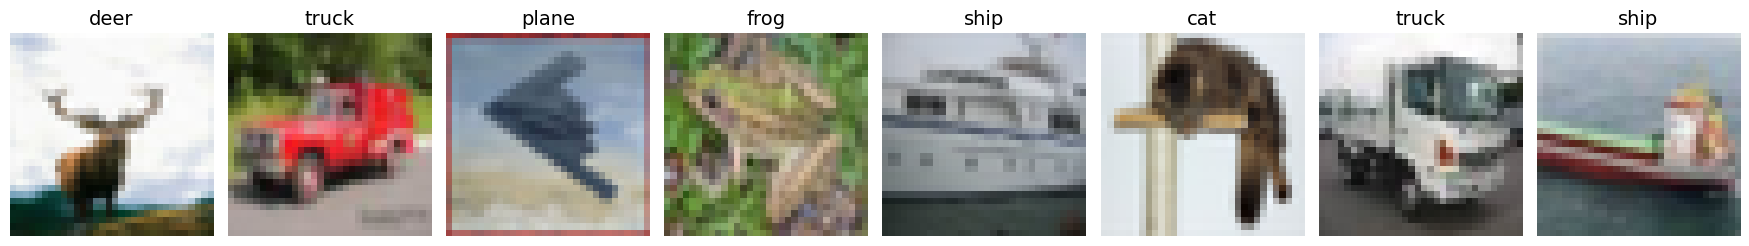

In [4]:
def imshow_grid_with_labels(images, labels, classes, num_images=8):
    images = images[:num_images]
    images = images / 2 + 0.5  # unnormalize

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2.2, 3))

    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]], fontsize=14)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow_grid_with_labels(images, labels, classes, num_images=8)

# Making our model

## Specify our target class
This code converts the original 10-class CIFAR-10 labels into binary labels for a cat vs. not-cat classification task by assigning a label of 1 to “cat” (class 3) and 0 to all other classes. Then, it creates subsets covering the full training (40 000 images), testing (5000 images) and validation (5000) splits and builds DataLoaders that efficiently batch and, in the case of training, shuffle the data for model training and evaluation.

In [5]:
target_class = 3  # 'cat'

# Convert CIFAR-10 dataset labels to binary: 1 = cat, 0 = not cat
def convert_to_binary(dataset, target_class=3):  # Default to 'cat' class (3)
    dataset.targets = [1 if label == target_class else 0 for label in dataset.targets]
    return dataset

# Apply conversion to binary classification for both train and test sets
trainset = convert_to_binary(trainset)
testset = convert_to_binary(testset)

# 40000 train, 5000 validation, 5000 test
train_subset = Subset(trainset, range(40000)) # Indices 0 to 39999 for training
valid_subset = Subset(trainset, range(40000, 45000))  # Indices 40000 to 44999 for validation
test_subset  = Subset(testset, range(5000))   # First 5000 images from test set for testing

# DataLoaders
trainLoader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
validLoader = torch.utils.data.DataLoader(valid_subset, batch_size=64, shuffle=False, num_workers=2)
testloader  = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

## The model we are using - ResNet18
We use ResNet because it’s a powerful, well-established deep convolutional neural network architecture that leverages residual (skip) connections. These connections allow very deep networks to be trained effectively by helping gradients flow backward through many layers. Additionally, ResNet models (like ResNet18) are widely pre-trained on large datasets like ImageNet, which enables effective transfer learning—meaning we can fine-tune the network for our specific task (in this case, binary classification of cat vs. not-cat)

In [6]:
# Load the ResNet18 model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


## Training-loop
This snippet sets up and runs a training loop for our binary classifier. We use the BCEWithLogitsLoss (which combines sigmoid activation and binary cross-entropy loss) along with the Adam optimizer. For each epoch, the code:
- Moves the images and labels to the device (CPU/GPU),
- Performs a forward pass through the model,
- Computes the loss,
- Backpropagates the gradients,
- Updates the model parameters.

We do this to iteratively minimize the loss so that our model learns to correctly classify images as “cat” (1) or “not cat” (0).

To run it, we were using a M3 Mac´s GPU, we then swapped to Google Colab (cuda) and could run much faster with more epochs.

In [7]:
# Loss function and optimizer
# Calculate pos_weight as the ratio of negatives to positives in the training set
# Adam optimizer with weight decay to prevent overfitting
pos_weight = torch.tensor([9.0], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 5

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in trainLoader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainLoader)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in validLoader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(validLoader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1, Train Loss: 0.8410, Validation Loss: 0.7444
Epoch 2, Train Loss: 0.6633, Validation Loss: 0.7142
Epoch 3, Train Loss: 0.6975, Validation Loss: 0.6931
Epoch 4, Train Loss: 0.5733, Validation Loss: 0.6520
Epoch 5, Train Loss: 0.5125, Validation Loss: 0.6407


We struggled a lot with the model overfitting, wich is why we added validation loss to the training loop, to indentify just how many epochs we could use before overfitting. The "pos_weight" helped a lot with reducing the amount of false negatives, effectively bettering our recall score. What it does is punishing the model for classifying a 'cat' as 'not cat'. These are common problems with imbalanced datasets where we are looking for a minority class.

The validation loss indicates if the model is startig to overfit (if it spikes and doesn´t recover). This is why we are using 5 epochs and not more, since the model started overfitting in epoch 6-7. This way we are getting optimal results.

# Evaluation
This snippet evaluates the model’s performance on the test data. It does the following:

- Sets the model to evaluation mode and disables gradient calculations (for efficiency).

- Iterates through the test dataset, moving images and labels to the correct device.

- Computes the model’s output, applies the sigmoid function to convert logits to probabilities, and thresholds at 0.5 to get  binary predictions.

- Compares predictions with the true labels and calculates measurements.

We do this to measure how well the trained model generalizes to unseen data without affecting its parameters.

In [8]:
# Get balanced indices (first n of each class)
cat_idx = [i for i, label in enumerate(testset.targets) if label == 1]
not_cat_idx = [i for i, label in enumerate(testset.targets) if label == 0]
n = min(len(cat_idx), len(not_cat_idx))
balanced_indices = cat_idx[:n] + not_cat_idx[:n]

# Create a DataLoader for the balanced test set
balanced_testloader = torch.utils.data.DataLoader(
    Subset(testset, balanced_indices), batch_size=64, shuffle=False, num_workers=2
)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in balanced_testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).long().squeeze()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print(classification_report(all_labels, all_preds, target_names=['not cat', 'cat']))

              precision    recall  f1-score   support

     not cat       0.83      0.82      0.83      1000
         cat       0.83      0.84      0.83      1000

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



## Confusion Matrix
This illustrates how often the model predicts correctly, and shows when the model predicts wrongly.
The Matrix illustrates that the model mostly predicts correct.

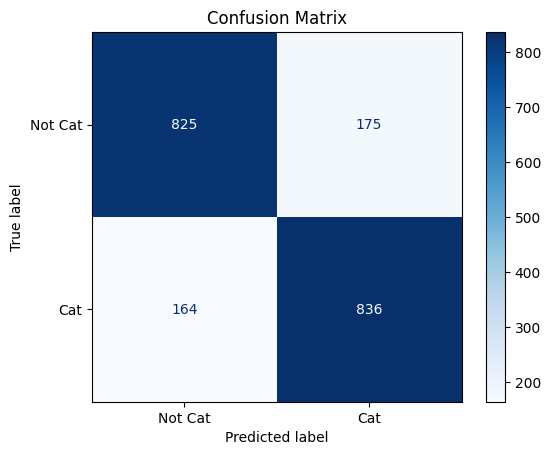

In [9]:
# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in balanced_testloader:
        images = images.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy())

# Compute and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Cat', 'Cat'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Testing with a random image
We found two random images of a cat and a dog on Google, and then resized them to fit CIFAR-10´s format we used for training (32x32).
We chose dog as the category we wanted to compare with, since it was the most similar class to cat. As you can see by the pictures below, our model correctly predicts if an image is of a cat or a dog. We used the same threshold as with the evaluation at 0.5

Prediction: Cat (confidence: 0.84)


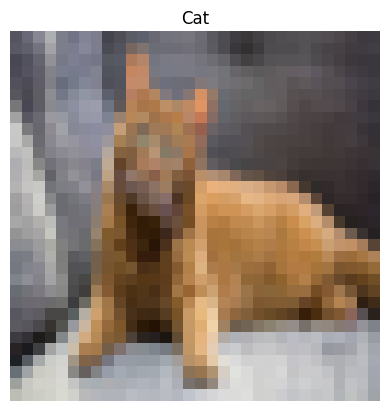

Prediction: Not Cat (confidence: 0.18)


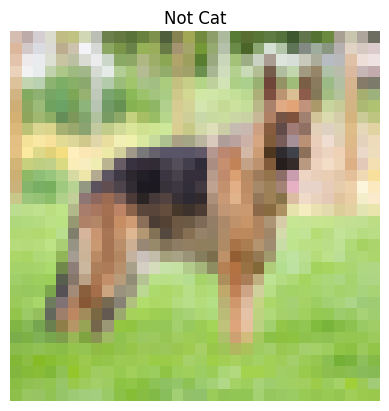

In [10]:
# Make sure we have the right transformations for prediction
predict_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Match CIFAR-10 image size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Match training normalization
])

def predict_image(img_path, model):
    model.eval()  # Set model to evaluation mode
    img = Image.open(img_path).convert('RGB')  # Open image
    img_tensor = predict_transform(img).unsqueeze(0).to(device)  # Apply transformations and move to device

    with torch.no_grad():
        output = model(img_tensor)  # Pass img_tensor to the model
        prob = torch.sigmoid(output).item()  # Apply sigmoid to get probability

    # Threshold for binary classification: 0.5 for cat vs not-cat
    result = "Cat" if prob > 0.5 else "Not Cat"
    print(f"Prediction: {result} (confidence: {prob:.2f})")

    # Show image with result title
    plt.imshow(img.resize((32, 32)))  # Resize to show what the model sees
    plt.title(result)
    plt.axis('off')
    plt.show()

# Finally, run:
predict_image("cat_image.jpg", model)
predict_image("dog_image.jpg", model)